# GSNR Computation: _LeNet-300_, BackPACK, MNIST & PyTorch

- [BackPACK](https://docs.backpack.pt/en/master/main-api.html)
- [reference](https://gist.github.com/andres-fr/db9d0ba31d1502df62a09d382e504d1e)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from backpack import extend, backpack
from backpack.extensions import BatchGrad, SumGradSquared, Variance

from tqdm import tqdm
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, pickle

/home/arjunm/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.12.1+cu102
Number of GPU(s) available = 0
PyTorch does not have access to GPU
Available device is cpu


In [3]:
# Define neural network hyper-parameters-
num_epochs = 70
batch_size = 256
learning_rate = 0.0012

In [4]:
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

# Define transforms-
transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [5]:
# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = '/home/arjunm/Downloads/.data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = '/home/arjunm/Downloads/.data', train = False,
        transform = transforms_apply
        )

In [6]:
print(f"len(train_dataset): {len(train_dataset)} & len(test_dataset): {len(test_dataset)}")

len(train_dataset): 60000 & len(test_dataset): 10000


In [7]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = True
        )

In [8]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [16]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))
print(f"images.shape: {images.shape}")

# De-normalize the batch of images-
images *= 255.0

images.shape: torch.Size([256, 1, 28, 28])


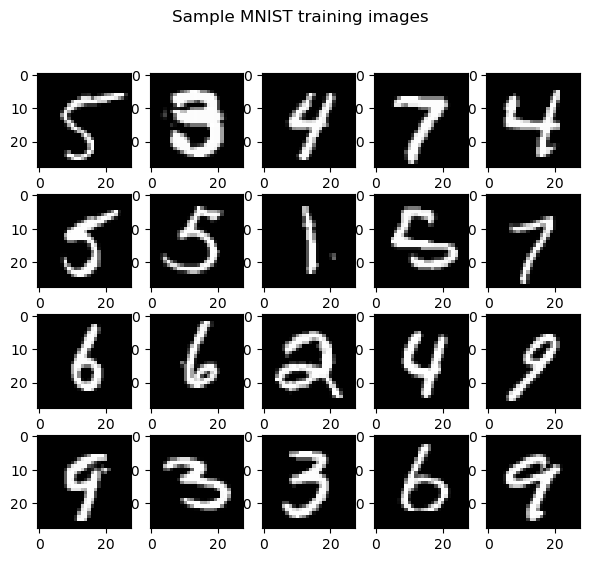

In [17]:
# Visualize 20 images from training set-
plt.figure(figsize = (7, 6))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [18]:
del images, labels

In [9]:
class LeNet300(nn.Module):
    def __init__(self):
        super(LeNet300, self).__init__()
    
        self.fc1 = nn.Linear(
            in_features = 784, out_features = 300,
            bias = True
        )
        self.fc2 = nn.Linear(
            in_features = 300, out_features = 100,
            bias = True
        )
        self.op_layer = nn.Linear(
            in_features = 100, out_features = 10,
            bias = True
        )
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.op_layer(x)
        
    

In [10]:
# Initialize LeNet-300 architecture-
model = LeNet300().to(device)

In [11]:
# Save randomly initialized parameters-
torch.save(model.state_dict(), "LeNet300_random_parameters.pth")

In [12]:
tot_params = 0
for param in model.parameters():
    print(f"layer: {param.shape} has {param.nelement()} params")
    tot_params += param.nelement()

del param

layer: torch.Size([300, 784]) has 235200 params
layer: torch.Size([300]) has 300 params
layer: torch.Size([100, 300]) has 30000 params
layer: torch.Size([100]) has 100 params
layer: torch.Size([10, 100]) has 1000 params
layer: torch.Size([10]) has 10 params


In [13]:
print(f"LeNet-300 CNN has {tot_params} total parameters")

LeNet-300 CNN has 266610 total parameters


In [14]:
# Define loss function and optimizer-
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params = model.parameters(), lr = 0.01,
    momentum = 0.0, weight_decay = 0
)

In [15]:
def initialize_gsnr(model):
    gsnr_d = {}
    i = 0
    
    for params in model.parameters():
        # gsnr_d[i] = torch.zeros_like(params)
        gsnr_d[i] = np.zeros_like(params.detach().cpu().numpy())
        i += 1
    
    del params
    
    return gsnr_d


In [16]:
# backpack wrapper for model and loss function-
model = extend(model)
loss_fn = extend(loss_fn)

In [17]:
# Required for GSNR computation-
EPSILON = 1e-5

In [18]:
gsnr_d = initialize_gsnr(model = model)

In [19]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(-1, 784)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss_fn(outputs, labels)
            
            # Call 'backward()' with backpack extensions-
            with backpack(
                # element-wise gradients, needed only for 'efficient' way-
                BatchGrad(),
                # (grad ^ 2) / var(grad) - memory efficient and easy-
                Variance(),
                # probably faster version with Var(X) = E[X^2] - (E[X]) ^ 2
                SumGradSquared()
            ):
                # Perform backprop-
                J.backward()
            
            # After having the required quantities, computer layer-wise GSNR-
            params = [param for param in model.parameters()]
            grads_sqrd = [(param.grad ** 2) for param in params]
            
            # Using built-in extensions (element-wise gradients not needed)-
            gsnr = [g_sqrd / (param.variance + EPSILON) for g_sqrd, param in zip(grads_sqrd, params)]
            
            # Update parameters-
            optimizer.step()
            
            # global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            # step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
            global gsnr_d
            for i in range(len(gsnr)):
                layer_grads_np = gsnr[i].detach().cpu().clone().numpy()
                gsnr_d[i] = gsnr_d[i] + layer_grads_np
            
            del layer_grads_np
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [20]:
def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                images = images.view(-1, 784)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss_fn(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [21]:
# Python3 dict to contain training metrics-
training_history = {}

# Initialize parameters saving 'best' models-
best_val_acc = 0
# loc_patience = 0

In [22]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}%"
          # f" & LR = {optimizer.param_groups[0]['lr']:.4f}
          f"\n")
    
    training_history[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        # 'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "LeNet300_best_model.pth")
        
        # Save Python3 dict containing GSNRs-
        with open("LeNet300_best_GSNRs.pkl", "wb") as file:
            pickle.dump(gsnr_d, file)
        
        

Training: :   0%|                                    | 0/235 [00:00<?, ?batch/s]/home/arjunm/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.LeNet300'> although the module has parameters
  warnings.warn(
/home/arjunm/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to variance does not have an extension for Module <class '__main__.LeNet300'> although the module has parameters
  warnings.warn(
/home/arjunm/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to sum_grad_squared does not have an extension for Module <class '__main__.LeNet300'> although the module has parameters
  warnings.warn(
Training: : 100%|█| 235/235 [00:15<00:00, 14.70batch/s, accuracy=78.7, loss=0.73
Validat


epoch: 1 training loss = 0.7307, training accuracy = 78.70%, val_loss = 0.3827, val_accuracy = 88.93%

Saving model with highest val_acc = 88.9300%



Training: : 100%|█| 235/235 [00:16<00:00, 14.58batch/s, accuracy=90, loss=0.348]
Validation: : 100%|█| 40/40 [00:01<00:00, 38.75batch/s, val_acc=91.3, val_loss=0



epoch: 2 training loss = 0.3475, training accuracy = 89.97%, val_loss = 0.2962, val_accuracy = 91.27%

Saving model with highest val_acc = 91.2700%



Training: : 100%|█| 235/235 [00:16<00:00, 13.94batch/s, accuracy=91.6, loss=0.28
Validation: : 100%|█| 40/40 [00:01<00:00, 39.70batch/s, val_acc=92.6, val_loss=0



epoch: 3 training loss = 0.2852, training accuracy = 91.61%, val_loss = 0.2574, val_accuracy = 92.56%

Saving model with highest val_acc = 92.5600%



Training: : 100%|█| 235/235 [00:16<00:00, 13.90batch/s, accuracy=92.7, loss=0.25
Validation: : 100%|█| 40/40 [00:01<00:00, 38.36batch/s, val_acc=93.3, val_loss=0



epoch: 4 training loss = 0.2507, training accuracy = 92.73%, val_loss = 0.2319, val_accuracy = 93.28%

Saving model with highest val_acc = 93.2800%



Training: : 100%|█| 235/235 [00:16<00:00, 14.16batch/s, accuracy=93.4, loss=0.22
Validation: : 100%|█| 40/40 [00:01<00:00, 38.77batch/s, val_acc=93.7, val_loss=0



epoch: 5 training loss = 0.2269, training accuracy = 93.45%, val_loss = 0.2149, val_accuracy = 93.74%

Saving model with highest val_acc = 93.7400%



Training: : 100%|█| 235/235 [00:16<00:00, 14.27batch/s, accuracy=94, loss=0.208]
Validation: : 100%|█| 40/40 [00:00<00:00, 40.10batch/s, val_acc=94.1, val_loss=0



epoch: 6 training loss = 0.2084, training accuracy = 94.01%, val_loss = 0.2007, val_accuracy = 94.10%

Saving model with highest val_acc = 94.1000%



Training: : 100%|█| 235/235 [00:16<00:00, 13.97batch/s, accuracy=94.4, loss=0.19
Validation: : 100%|█| 40/40 [00:01<00:00, 38.27batch/s, val_acc=94.6, val_loss=0



epoch: 7 training loss = 0.1936, training accuracy = 94.42%, val_loss = 0.1884, val_accuracy = 94.56%

Saving model with highest val_acc = 94.5600%



Training: : 100%|█| 235/235 [00:16<00:00, 14.40batch/s, accuracy=94.8, loss=0.18
Validation: : 100%|█| 40/40 [00:01<00:00, 38.43batch/s, val_acc=94.6, val_loss=0



epoch: 8 training loss = 0.1812, training accuracy = 94.78%, val_loss = 0.1839, val_accuracy = 94.59%

Saving model with highest val_acc = 94.5900%



Training: : 100%|█| 235/235 [00:16<00:00, 14.07batch/s, accuracy=95.1, loss=0.17
Validation: : 100%|█| 40/40 [00:00<00:00, 40.27batch/s, val_acc=95, val_loss=0.1



epoch: 9 training loss = 0.1706, training accuracy = 95.09%, val_loss = 0.1716, val_accuracy = 94.98%

Saving model with highest val_acc = 94.9800%



Training: : 100%|█| 235/235 [00:17<00:00, 13.52batch/s, accuracy=95.3, loss=0.16
Validation: : 100%|█| 40/40 [00:01<00:00, 34.27batch/s, val_acc=95.2, val_loss=0



epoch: 10 training loss = 0.1613, training accuracy = 95.32%, val_loss = 0.1630, val_accuracy = 95.19%

Saving model with highest val_acc = 95.1900%



Training: : 100%|█| 235/235 [00:17<00:00, 13.52batch/s, accuracy=95.6, loss=0.15
Validation: : 100%|█| 40/40 [00:01<00:00, 36.81batch/s, val_acc=95.4, val_loss=0



epoch: 11 training loss = 0.1530, training accuracy = 95.60%, val_loss = 0.1556, val_accuracy = 95.38%

Saving model with highest val_acc = 95.3800%



Training: : 100%|█| 235/235 [00:17<00:00, 13.57batch/s, accuracy=95.8, loss=0.14
Validation: : 100%|█| 40/40 [00:01<00:00, 36.98batch/s, val_acc=95.4, val_loss=0



epoch: 12 training loss = 0.1456, training accuracy = 95.82%, val_loss = 0.1518, val_accuracy = 95.41%

Saving model with highest val_acc = 95.4100%



Training: : 100%|█| 235/235 [00:17<00:00, 13.80batch/s, accuracy=96.1, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 37.27batch/s, val_acc=95.6, val_loss=0



epoch: 13 training loss = 0.1390, training accuracy = 96.06%, val_loss = 0.1460, val_accuracy = 95.60%

Saving model with highest val_acc = 95.6000%



Training: : 100%|█| 235/235 [00:16<00:00, 13.99batch/s, accuracy=96.2, loss=0.13
Validation: : 100%|█| 40/40 [00:01<00:00, 36.90batch/s, val_acc=95.6, val_loss=0



epoch: 14 training loss = 0.1330, training accuracy = 96.25%, val_loss = 0.1420, val_accuracy = 95.62%

Saving model with highest val_acc = 95.6200%



Training: : 100%|█| 235/235 [00:16<00:00, 13.83batch/s, accuracy=96.4, loss=0.12
Validation: : 100%|█| 40/40 [00:01<00:00, 34.87batch/s, val_acc=95.8, val_loss=0



epoch: 15 training loss = 0.1276, training accuracy = 96.41%, val_loss = 0.1383, val_accuracy = 95.77%

Saving model with highest val_acc = 95.7700%



Training: : 100%|█| 235/235 [00:17<00:00, 13.79batch/s, accuracy=96.6, loss=0.12
Validation: : 100%|█| 40/40 [00:01<00:00, 39.26batch/s, val_acc=95.9, val_loss=0



epoch: 16 training loss = 0.1225, training accuracy = 96.57%, val_loss = 0.1342, val_accuracy = 95.89%

Saving model with highest val_acc = 95.8900%



Training: : 100%|█| 235/235 [00:17<00:00, 13.79batch/s, accuracy=96.7, loss=0.11
Validation: : 100%|█| 40/40 [00:01<00:00, 39.83batch/s, val_acc=96, val_loss=0.1



epoch: 17 training loss = 0.1180, training accuracy = 96.67%, val_loss = 0.1301, val_accuracy = 95.95%

Saving model with highest val_acc = 95.9500%



Training: : 100%|█| 235/235 [00:17<00:00, 13.82batch/s, accuracy=96.8, loss=0.11
Validation: : 100%|█| 40/40 [00:01<00:00, 37.97batch/s, val_acc=96, val_loss=0.1



epoch: 18 training loss = 0.1136, training accuracy = 96.83%, val_loss = 0.1286, val_accuracy = 96.00%

Saving model with highest val_acc = 96.0000%



Training: : 100%|██| 235/235 [00:17<00:00, 13.40batch/s, accuracy=97, loss=0.11]
Validation: : 100%|█| 40/40 [00:01<00:00, 34.46batch/s, val_acc=96.1, val_loss=0



epoch: 19 training loss = 0.1096, training accuracy = 96.95%, val_loss = 0.1246, val_accuracy = 96.10%

Saving model with highest val_acc = 96.1000%



Training: : 100%|█| 235/235 [00:16<00:00, 14.22batch/s, accuracy=97, loss=0.106]
Validation: : 100%|█| 40/40 [00:01<00:00, 38.87batch/s, val_acc=96.3, val_loss=0



epoch: 20 training loss = 0.1057, training accuracy = 97.04%, val_loss = 0.1220, val_accuracy = 96.27%

Saving model with highest val_acc = 96.2700%



Training: : 100%|█| 235/235 [00:17<00:00, 13.07batch/s, accuracy=97.1, loss=0.10
Validation: : 100%|█| 40/40 [00:01<00:00, 36.09batch/s, val_acc=96.2, val_loss=0



epoch: 21 training loss = 0.1023, training accuracy = 97.11%, val_loss = 0.1185, val_accuracy = 96.22%



Training: : 100%|█| 235/235 [00:16<00:00, 14.14batch/s, accuracy=97.2, loss=0.09
Validation: : 100%|█| 40/40 [00:01<00:00, 38.78batch/s, val_acc=96.3, val_loss=0



epoch: 22 training loss = 0.0991, training accuracy = 97.22%, val_loss = 0.1163, val_accuracy = 96.32%

Saving model with highest val_acc = 96.3200%



Training: : 100%|█| 235/235 [00:16<00:00, 14.25batch/s, accuracy=97.3, loss=0.09
Validation: : 100%|█| 40/40 [00:01<00:00, 37.38batch/s, val_acc=96.4, val_loss=0



epoch: 23 training loss = 0.0960, training accuracy = 97.31%, val_loss = 0.1148, val_accuracy = 96.37%

Saving model with highest val_acc = 96.3700%



Training: : 100%|█| 235/235 [00:16<00:00, 14.27batch/s, accuracy=97.4, loss=0.09
Validation: : 100%|█| 40/40 [00:01<00:00, 39.16batch/s, val_acc=96.5, val_loss=0



epoch: 24 training loss = 0.0929, training accuracy = 97.40%, val_loss = 0.1123, val_accuracy = 96.55%

Saving model with highest val_acc = 96.5500%



Training: : 100%|█| 235/235 [00:16<00:00, 14.22batch/s, accuracy=97.5, loss=0.09
Validation: : 100%|█| 40/40 [00:01<00:00, 38.89batch/s, val_acc=96.5, val_loss=0



epoch: 25 training loss = 0.0903, training accuracy = 97.50%, val_loss = 0.1120, val_accuracy = 96.53%



Training: : 100%|█| 235/235 [00:16<00:00, 14.29batch/s, accuracy=97.5, loss=0.08
Validation: : 100%|█| 40/40 [00:01<00:00, 38.45batch/s, val_acc=96.6, val_loss=0



epoch: 26 training loss = 0.0876, training accuracy = 97.55%, val_loss = 0.1100, val_accuracy = 96.56%

Saving model with highest val_acc = 96.5600%



Training: : 100%|█| 235/235 [00:16<00:00, 14.25batch/s, accuracy=97.7, loss=0.08
Validation: : 100%|█| 40/40 [00:01<00:00, 38.35batch/s, val_acc=96.7, val_loss=0



epoch: 27 training loss = 0.0850, training accuracy = 97.66%, val_loss = 0.1067, val_accuracy = 96.66%

Saving model with highest val_acc = 96.6600%



Training: : 100%|█| 235/235 [00:16<00:00, 14.28batch/s, accuracy=97.7, loss=0.08
Validation: : 100%|█| 40/40 [00:01<00:00, 39.29batch/s, val_acc=96.6, val_loss=0



epoch: 28 training loss = 0.0828, training accuracy = 97.70%, val_loss = 0.1085, val_accuracy = 96.64%



Training: : 100%|█| 235/235 [00:16<00:00, 14.34batch/s, accuracy=97.8, loss=0.08
Validation: : 100%|█| 40/40 [00:01<00:00, 37.53batch/s, val_acc=96.8, val_loss=0



epoch: 29 training loss = 0.0804, training accuracy = 97.79%, val_loss = 0.1043, val_accuracy = 96.75%

Saving model with highest val_acc = 96.7500%



Training: : 100%|█| 235/235 [00:16<00:00, 14.23batch/s, accuracy=97.9, loss=0.07
Validation: : 100%|█| 40/40 [00:01<00:00, 38.79batch/s, val_acc=96.8, val_loss=0



epoch: 30 training loss = 0.0782, training accuracy = 97.88%, val_loss = 0.1043, val_accuracy = 96.78%

Saving model with highest val_acc = 96.7800%



Training: : 100%|█| 235/235 [00:16<00:00, 14.25batch/s, accuracy=97.9, loss=0.07
Validation: : 100%|█| 40/40 [00:01<00:00, 39.13batch/s, val_acc=96.7, val_loss=0



epoch: 31 training loss = 0.0761, training accuracy = 97.91%, val_loss = 0.1022, val_accuracy = 96.74%



Training: : 100%|█| 235/235 [00:16<00:00, 13.93batch/s, accuracy=98, loss=0.0741
Validation: : 100%|█| 40/40 [00:01<00:00, 38.81batch/s, val_acc=96.8, val_loss=0



epoch: 32 training loss = 0.0741, training accuracy = 98.00%, val_loss = 0.1007, val_accuracy = 96.79%

Saving model with highest val_acc = 96.7900%



Training: : 100%|█| 235/235 [00:17<00:00, 13.72batch/s, accuracy=98.1, loss=0.07
Validation: : 100%|█| 40/40 [00:01<00:00, 37.16batch/s, val_acc=96.9, val_loss=0



epoch: 33 training loss = 0.0722, training accuracy = 98.06%, val_loss = 0.0991, val_accuracy = 96.87%

Saving model with highest val_acc = 96.8700%



Training: : 100%|█| 235/235 [00:17<00:00, 13.42batch/s, accuracy=98.1, loss=0.07
Validation: : 100%|█| 40/40 [00:01<00:00, 39.96batch/s, val_acc=96.9, val_loss=0



epoch: 34 training loss = 0.0705, training accuracy = 98.08%, val_loss = 0.0989, val_accuracy = 96.86%



Training: : 100%|█| 235/235 [00:17<00:00, 13.22batch/s, accuracy=98.1, loss=0.06
Validation: : 100%|█| 40/40 [00:01<00:00, 38.25batch/s, val_acc=96.8, val_loss=0



epoch: 35 training loss = 0.0685, training accuracy = 98.14%, val_loss = 0.0981, val_accuracy = 96.82%



Training: : 100%|█| 235/235 [00:16<00:00, 14.08batch/s, accuracy=98.2, loss=0.06
Validation: : 100%|█| 40/40 [00:01<00:00, 34.08batch/s, val_acc=96.9, val_loss=0



epoch: 36 training loss = 0.0669, training accuracy = 98.20%, val_loss = 0.0969, val_accuracy = 96.92%

Saving model with highest val_acc = 96.9200%



Training: : 100%|█| 235/235 [00:16<00:00, 13.98batch/s, accuracy=98.3, loss=0.06
Validation: : 100%|█| 40/40 [00:01<00:00, 37.25batch/s, val_acc=97, val_loss=0.0



epoch: 37 training loss = 0.0653, training accuracy = 98.26%, val_loss = 0.0956, val_accuracy = 96.97%

Saving model with highest val_acc = 96.9700%



Training: : 100%|█| 235/235 [00:16<00:00, 13.96batch/s, accuracy=98.3, loss=0.06
Validation: : 100%|█| 40/40 [00:01<00:00, 39.77batch/s, val_acc=97.1, val_loss=0



epoch: 38 training loss = 0.0636, training accuracy = 98.28%, val_loss = 0.0938, val_accuracy = 97.09%

Saving model with highest val_acc = 97.0900%



Training: : 100%|█| 235/235 [00:16<00:00, 13.98batch/s, accuracy=98.4, loss=0.06
Validation: : 100%|█| 40/40 [00:00<00:00, 40.87batch/s, val_acc=97, val_loss=0.0



epoch: 39 training loss = 0.0621, training accuracy = 98.35%, val_loss = 0.0942, val_accuracy = 96.99%



Training: : 100%|█| 235/235 [00:16<00:00, 13.96batch/s, accuracy=98.4, loss=0.06
Validation: : 100%|█| 40/40 [00:01<00:00, 39.75batch/s, val_acc=97, val_loss=0.0



epoch: 40 training loss = 0.0606, training accuracy = 98.39%, val_loss = 0.0939, val_accuracy = 97.05%



Training: : 100%|█| 235/235 [00:16<00:00, 14.00batch/s, accuracy=98.4, loss=0.05
Validation: : 100%|█| 40/40 [00:00<00:00, 40.32batch/s, val_acc=97.1, val_loss=0



epoch: 41 training loss = 0.0592, training accuracy = 98.43%, val_loss = 0.0918, val_accuracy = 97.10%

Saving model with highest val_acc = 97.1000%



Training: : 100%|█| 235/235 [00:16<00:00, 13.91batch/s, accuracy=98.5, loss=0.05
Validation: : 100%|█| 40/40 [00:01<00:00, 38.87batch/s, val_acc=97, val_loss=0.0



epoch: 42 training loss = 0.0578, training accuracy = 98.46%, val_loss = 0.0927, val_accuracy = 97.00%



Training: : 100%|█| 235/235 [00:16<00:00, 13.90batch/s, accuracy=98.5, loss=0.05
Validation: : 100%|█| 40/40 [00:01<00:00, 37.21batch/s, val_acc=97.1, val_loss=0



epoch: 43 training loss = 0.0564, training accuracy = 98.50%, val_loss = 0.0907, val_accuracy = 97.11%

Saving model with highest val_acc = 97.1100%



Training: : 100%|█| 235/235 [00:16<00:00, 13.93batch/s, accuracy=98.5, loss=0.05
Validation: : 100%|█| 40/40 [00:00<00:00, 40.06batch/s, val_acc=97.1, val_loss=0



epoch: 44 training loss = 0.0550, training accuracy = 98.54%, val_loss = 0.0899, val_accuracy = 97.13%

Saving model with highest val_acc = 97.1300%



Training: : 100%|█| 235/235 [00:16<00:00, 13.90batch/s, accuracy=98.6, loss=0.05
Validation: : 100%|█| 40/40 [00:00<00:00, 40.74batch/s, val_acc=97.2, val_loss=0



epoch: 45 training loss = 0.0539, training accuracy = 98.57%, val_loss = 0.0883, val_accuracy = 97.17%

Saving model with highest val_acc = 97.1700%



Training: : 100%|█| 235/235 [00:16<00:00, 13.96batch/s, accuracy=98.6, loss=0.05
Validation: : 100%|█| 40/40 [00:00<00:00, 41.19batch/s, val_acc=97.1, val_loss=0



epoch: 46 training loss = 0.0526, training accuracy = 98.61%, val_loss = 0.0890, val_accuracy = 97.14%



Training: : 100%|█| 235/235 [00:16<00:00, 13.89batch/s, accuracy=98.7, loss=0.05
Validation: : 100%|█| 40/40 [00:01<00:00, 37.76batch/s, val_acc=97.2, val_loss=0



epoch: 47 training loss = 0.0513, training accuracy = 98.66%, val_loss = 0.0880, val_accuracy = 97.19%

Saving model with highest val_acc = 97.1900%



Training: : 100%|█| 235/235 [00:16<00:00, 13.88batch/s, accuracy=98.7, loss=0.05
Validation: : 100%|█| 40/40 [00:00<00:00, 40.77batch/s, val_acc=97.3, val_loss=0



epoch: 48 training loss = 0.0502, training accuracy = 98.72%, val_loss = 0.0870, val_accuracy = 97.28%

Saving model with highest val_acc = 97.2800%



Training: : 100%|█| 235/235 [00:16<00:00, 13.96batch/s, accuracy=98.7, loss=0.04
Validation: : 100%|█| 40/40 [00:00<00:00, 41.29batch/s, val_acc=97.2, val_loss=0



epoch: 49 training loss = 0.0492, training accuracy = 98.74%, val_loss = 0.0867, val_accuracy = 97.22%



Training: : 100%|█| 235/235 [00:16<00:00, 14.00batch/s, accuracy=98.8, loss=0.04
Validation: : 100%|█| 40/40 [00:01<00:00, 38.54batch/s, val_acc=97.4, val_loss=0



epoch: 50 training loss = 0.0481, training accuracy = 98.75%, val_loss = 0.0859, val_accuracy = 97.35%

Saving model with highest val_acc = 97.3500%



Training: : 100%|█| 235/235 [00:16<00:00, 13.93batch/s, accuracy=98.8, loss=0.04
Validation: : 100%|█| 40/40 [00:00<00:00, 40.08batch/s, val_acc=97.2, val_loss=0



epoch: 51 training loss = 0.0469, training accuracy = 98.79%, val_loss = 0.0869, val_accuracy = 97.25%



Training: : 100%|█| 235/235 [00:16<00:00, 13.97batch/s, accuracy=98.8, loss=0.04
Validation: : 100%|█| 40/40 [00:01<00:00, 37.73batch/s, val_acc=97.3, val_loss=0



epoch: 52 training loss = 0.0459, training accuracy = 98.85%, val_loss = 0.0860, val_accuracy = 97.28%



Training: : 100%|█| 235/235 [00:16<00:00, 14.06batch/s, accuracy=98.9, loss=0.04
Validation: : 100%|█| 40/40 [00:01<00:00, 38.59batch/s, val_acc=97.2, val_loss=0



epoch: 53 training loss = 0.0449, training accuracy = 98.87%, val_loss = 0.0857, val_accuracy = 97.20%



Training: : 100%|█| 235/235 [00:16<00:00, 13.94batch/s, accuracy=98.9, loss=0.04
Validation: : 100%|█| 40/40 [00:01<00:00, 38.90batch/s, val_acc=97.4, val_loss=0



epoch: 54 training loss = 0.0440, training accuracy = 98.88%, val_loss = 0.0839, val_accuracy = 97.37%

Saving model with highest val_acc = 97.3700%



Training: : 100%|█| 235/235 [00:16<00:00, 13.87batch/s, accuracy=98.9, loss=0.04
Validation: : 100%|█| 40/40 [00:01<00:00, 39.57batch/s, val_acc=97.4, val_loss=0



epoch: 55 training loss = 0.0431, training accuracy = 98.92%, val_loss = 0.0844, val_accuracy = 97.42%

Saving model with highest val_acc = 97.4200%



Training: : 100%|█| 235/235 [00:16<00:00, 14.08batch/s, accuracy=99, loss=0.0421
Validation: : 100%|█| 40/40 [00:00<00:00, 41.01batch/s, val_acc=97.3, val_loss=0



epoch: 56 training loss = 0.0421, training accuracy = 98.97%, val_loss = 0.0839, val_accuracy = 97.30%



Training: : 100%|█| 235/235 [00:16<00:00, 13.91batch/s, accuracy=99, loss=0.0413
Validation: : 100%|█| 40/40 [00:01<00:00, 37.74batch/s, val_acc=97.4, val_loss=0



epoch: 57 training loss = 0.0413, training accuracy = 98.98%, val_loss = 0.0832, val_accuracy = 97.39%



Training: : 100%|█| 235/235 [00:16<00:00, 14.17batch/s, accuracy=99, loss=0.0403
Validation: : 100%|█| 40/40 [00:01<00:00, 38.56batch/s, val_acc=97.4, val_loss=0



epoch: 58 training loss = 0.0403, training accuracy = 99.02%, val_loss = 0.0831, val_accuracy = 97.40%



Training: : 100%|█| 235/235 [00:16<00:00, 13.92batch/s, accuracy=99, loss=0.0395
Validation: : 100%|█| 40/40 [00:00<00:00, 40.74batch/s, val_acc=97.4, val_loss=0



epoch: 59 training loss = 0.0395, training accuracy = 99.05%, val_loss = 0.0828, val_accuracy = 97.41%



Training: : 100%|█| 235/235 [00:16<00:00, 14.14batch/s, accuracy=99.1, loss=0.03
Validation: : 100%|█| 40/40 [00:01<00:00, 37.50batch/s, val_acc=97.4, val_loss=0



epoch: 60 training loss = 0.0387, training accuracy = 99.07%, val_loss = 0.0823, val_accuracy = 97.44%

Saving model with highest val_acc = 97.4400%



Training: : 100%|█| 235/235 [00:16<00:00, 13.84batch/s, accuracy=99.1, loss=0.03
Validation: : 100%|█| 40/40 [00:01<00:00, 39.10batch/s, val_acc=97.5, val_loss=0



epoch: 61 training loss = 0.0379, training accuracy = 99.12%, val_loss = 0.0824, val_accuracy = 97.45%

Saving model with highest val_acc = 97.4500%



Training: : 100%|█| 235/235 [00:16<00:00, 14.17batch/s, accuracy=99.1, loss=0.03
Validation: : 100%|█| 40/40 [00:01<00:00, 39.88batch/s, val_acc=97.4, val_loss=0



epoch: 62 training loss = 0.0371, training accuracy = 99.12%, val_loss = 0.0818, val_accuracy = 97.42%



Training: : 100%|█| 235/235 [00:16<00:00, 14.09batch/s, accuracy=99.1, loss=0.03
Validation: : 100%|█| 40/40 [00:00<00:00, 40.91batch/s, val_acc=97.5, val_loss=0



epoch: 63 training loss = 0.0363, training accuracy = 99.13%, val_loss = 0.0810, val_accuracy = 97.47%

Saving model with highest val_acc = 97.4700%



Training: : 100%|█| 235/235 [00:16<00:00, 14.06batch/s, accuracy=99.2, loss=0.03
Validation: : 100%|█| 40/40 [00:01<00:00, 37.86batch/s, val_acc=97.4, val_loss=0



epoch: 64 training loss = 0.0355, training accuracy = 99.17%, val_loss = 0.0815, val_accuracy = 97.42%



Training: : 100%|█| 235/235 [00:16<00:00, 14.19batch/s, accuracy=99.2, loss=0.03
Validation: : 100%|█| 40/40 [00:01<00:00, 36.67batch/s, val_acc=97.5, val_loss=0



epoch: 65 training loss = 0.0348, training accuracy = 99.23%, val_loss = 0.0810, val_accuracy = 97.46%



Training: : 100%|█| 235/235 [00:16<00:00, 13.84batch/s, accuracy=99.2, loss=0.03
Validation: : 100%|█| 40/40 [00:01<00:00, 39.84batch/s, val_acc=97.4, val_loss=0



epoch: 66 training loss = 0.0340, training accuracy = 99.21%, val_loss = 0.0811, val_accuracy = 97.37%



Training: : 100%|█| 235/235 [00:17<00:00, 13.75batch/s, accuracy=99.3, loss=0.03
Validation: : 100%|█| 40/40 [00:00<00:00, 40.07batch/s, val_acc=97.5, val_loss=0



epoch: 67 training loss = 0.0334, training accuracy = 99.26%, val_loss = 0.0804, val_accuracy = 97.52%

Saving model with highest val_acc = 97.5200%



Training: : 100%|█| 235/235 [00:16<00:00, 14.18batch/s, accuracy=99.3, loss=0.03
Validation: : 100%|█| 40/40 [00:00<00:00, 40.89batch/s, val_acc=97.5, val_loss=0



epoch: 68 training loss = 0.0328, training accuracy = 99.27%, val_loss = 0.0803, val_accuracy = 97.46%



Training: : 100%|█| 235/235 [00:16<00:00, 14.16batch/s, accuracy=99.3, loss=0.03
Validation: : 100%|█| 40/40 [00:01<00:00, 39.78batch/s, val_acc=97.5, val_loss=0



epoch: 69 training loss = 0.0321, training accuracy = 99.28%, val_loss = 0.0798, val_accuracy = 97.51%



Training: : 100%|█| 235/235 [00:16<00:00, 14.09batch/s, accuracy=99.3, loss=0.03
Validation: : 100%|█| 40/40 [00:00<00:00, 40.76batch/s, val_acc=97.5, val_loss=0


epoch: 70 training loss = 0.0314, training accuracy = 99.30%, val_loss = 0.0798, val_accuracy = 97.55%

Saving model with highest val_acc = 97.5500%



In [23]:
# Save training metrics as Python3 history for later analysis-
with open("LeNet300_training_history.pkl", "wb") as file:
    pickle.dump(training_history, file)

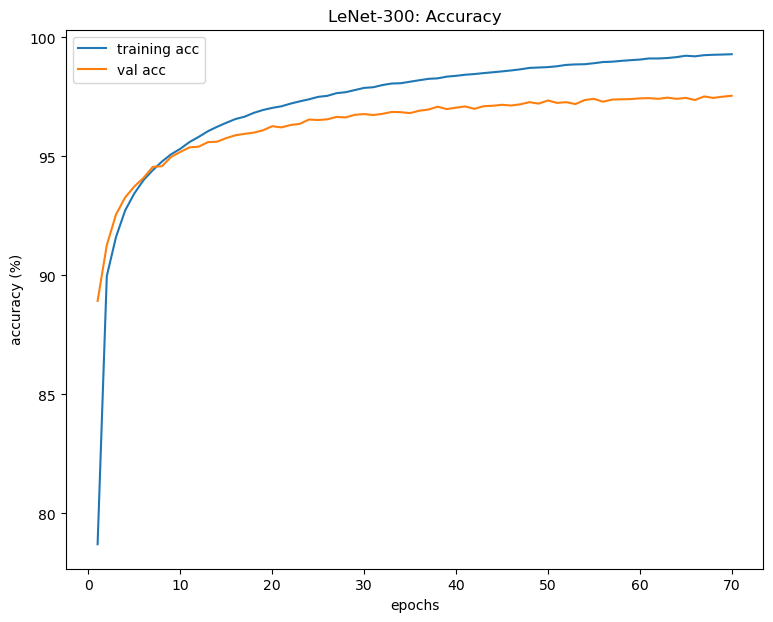

In [24]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['acc'] for k in training_history.keys()], label = 'training acc')
plt.plot(list(training_history.keys()), [training_history[k]['val_acc'] for k in training_history.keys()], label = 'val acc')
plt.title("LeNet-300: Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

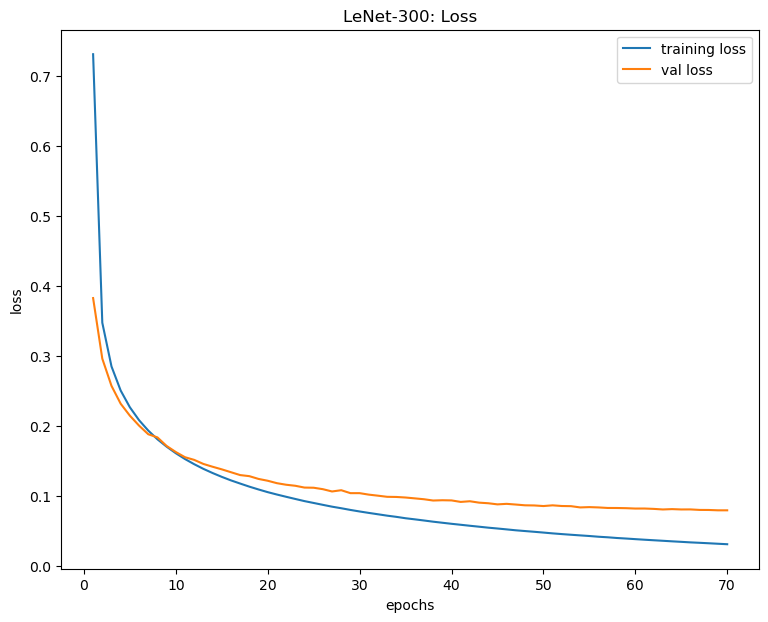

In [25]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['loss'] for k in training_history.keys()], label = 'training loss')
plt.plot(list(training_history.keys()), [training_history[k]['val_loss'] for k in training_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("LeNet-300: Loss")
plt.show()

In [ ]:
"""
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['lr'] for k in training_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LeNet-5: Learning-Rate")
plt.show()
"""